## ENCODE shRNA Knockdown differential splicing analysis

This notebook refers to the RNA splicing analysis of RNA-seq data targeting the knockdown of RNA binding proteins (RBPs) related with splicing regulation. 
Particularly, the goal is to identify exons that are sensitive to the knockdown of indiviaul RBPs to then ask the deep learning model whether he is sensitive to perturbations of those same RBPs. 98 RBPs were associated with RNA splicing regulation, but only 72 had RNA-Seq data available for the HepG2 cell line, the ones we are working with here.

Analysis was performed with a popular tool that reports binary events, rMATS v4.1.2.

In [1]:
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
from plotnine import *

### Majiq

Instead of correcting batch effects ourselves, we took advantage of [available processed data](https://zenodo.org/records/4294189), as part of [MOCCASING's manuscript](https://www.nature.com/articles/s41467-021-23608-9) (a batch-effect correction method for splicing quantifications).

In [2]:
# Download the data
#! curl "https://zenodo.org/records/4294189/files/encode_corrected.zip?download=1" --output encode_corrected.zip && unzip encode_corrected.zip
#! mv encode_corrected/ENCODE_BeforeAndAfterMOCCASIN.voila.tsv.zip . && rm -rf encode_corrected __MACOSX encode_corrected.zip
#! mv ENCODE_BeforeAndAfterMOCCASIN.voila.tsv.zip MajiqEncodeBatchCorrected.voila.tsv.zip

In [ ]:
splicing_rbps = pd.read_csv("Splicing_RBPs.txt", sep="\t", header=None).iloc[:,0].tolist()

In [ ]:
#orig_data = pd.read_csv("MAJIQ/MajiqEncodeBatchCorrected.voila.tsv.zip", compression='zip', sep="\t")

In [ ]:
# Drop data from K562 cell line and before batch correction
#cols_to_remove = [col for col in orig_data.columns if "BeforeMOCCASIN" in col or "K562" in col]
#data = orig_data.drop(columns=cols_to_remove)

In [ ]:
#data.columns = [x.replace("AfterMOCCASIN_HepG2_polyA_", "") for x in data.columns]

Some experiments have both CRISPR and shRNA knockdown. Priority will be given to the former. Also, 5 splicing RPBs (as identified in the ENCODE paper) are missing in this dataset: 

In [ ]:
# RBPs with CRISPR knockdown
CRISPR_EXPERIMENTS = [
    "EIF3H",
    "RBM5",
    "EXOSC5",
    "IGF2BP1",
    "NOLC1",
    "SRSF7",
    "SDAD1",
    "SRSF4",
    "DROSHA",
    "RBM14",
    "RPLP0",
    "CDC40",
    "HNRNPF",
    "AGGF1",
    "DDX21",
]

# RBPs with both CRISPR and shRNA knockdown
# Prioriry will be given to shRNA
CRISPR_shRNA_EXPERIMENTS = ["IGF2BP1", "SRSF7", "RPLP0", "HNRNPF", "DDX21"]

# Missing RBPs in Hepg2 
#MISSING_SPLICING_RBPS = [rbp for rbp in splicing_rbps if not any(rbp in col for col in data.columns)]
# ['AQR', 'DDX20', 'DDX42', 'FUBP1', 'HNRNPH1', 'PPP1R8']

In [ ]:
# Remove CRISPR knockdown experiments for those RBPs with both CRISPR and shRNA knockdown
#cols_to_remove = [col for col in data.columns if any(f"CRISPR_{rbp}" in col for rbp in CRISPR_shRNA_EXPERIMENTS)]
#data = data.drop(columns=cols_to_remove)

In [ ]:
# Final columns to keep
#cols_to_keep = ["lsv_id", "junction_id"] + [col for col in data.columns if any(rbp in col and '_tnom_score' not in col for rbp in splicing_rbps)]
#data = data[cols_to_keep]
#assert len(data.columns) == 530

In [ ]:
# Simplify column names
# new_col_names = ['lsv_id', 'junction_id']
# for col in data.columns[2:]:
#     c = col.split("_")[1] + "_" + col.split("_")[2]
#     if 'CTRL E(PSI)' in col:
#         c += '_ctrl_psi'
#     elif 'E(PSI)' in col:
#         c += '_kd_psi'
#     elif '_TNOM' in col:
#         c += '_tnom'
#     elif '_TTEST' in col:
#         c += '_ttest'
#     elif '_WILCOXON' in col:
#         c += '_wilcoxon'
#     elif '_dPSI' in col:
#         c += '_dpsi'
#     else:
#         print(col)
#         print("erro") 
#     new_col_names.append(c)
# data.columns = new_col_names

In [ ]:
#data.to_csv('MAJIQ/MajiqEncodeBatchCorrected_simplified.tsv.gz', sep='\t', compression='gzip', index=False)

#### Load simplified data

In [ ]:
data = pd.read_csv("MAJIQ/MajiqEncodeBatchCorrected_simplified.tsv.gz", sep="\t")

In [ ]:
c = ['lsv_id', 'junction_id']
data[c] = data[c].apply(lambda x: x.str.replace("gene:", ""))

In [ ]:
CHANGED, NON_CHANGED = [], []
for rbp in splicing_rbps:
    _data = data.copy()
    _data = _data[
        ["lsv_id", "junction_id"]
        + [col for col in data.columns if col.startswith(rbp + "_")]
    ]

    # No MAJIQ data for this RBP
    if _data.shape[1] == 2:
        print(f"Skipping {rbp}")
        continue
    psi_g1_col = [col for col in _data.columns if col.endswith("_ctrl_psi")][0]
    psi_g2_col = [col for col in _data.columns if col.endswith("_kd_psi")][0]
    dpsi_col = [col for col in _data.columns if col.endswith("_dpsi")][0]
    stat_test_col = [col for col in _data.columns if col.endswith("_wilcoxon")][0]
    _non_changed = _data[
        (_data[stat_test_col] <= 0.1) & (_data[dpsi_col].abs() < 0.02)
    ]
    _changed = _data[(_data[stat_test_col] <= 0.05) & (_data[dpsi_col].abs() >= 0.1)]
    
    to_rename = {
            dpsi_col: "dpsi",
            stat_test_col: "wilcoxon_pval",
            psi_g1_col: "psi_ctrl",
            psi_g2_col: "psi_kd",
        }
    _changed = _changed.rename(
        columns=to_rename
    )
    _changed["rbp"] = rbp
    _non_changed = _non_changed.rename(
        columns=to_rename
    )
    _non_changed["rbp"] = rbp
    out_cols = [
        "lsv_id",
        "junction_id",
        "psi_ctrl",
        "psi_kd",
        "dpsi",
        "wilcoxon_pval",
        "rbp",
    ]
    CHANGED.append(_changed[out_cols])
    NON_CHANGED.append(_non_changed[out_cols])

CHANGED = pd.concat(CHANGED)
NON_CHANGED = pd.concat(NON_CHANGED)

Skipping AQR
Skipping DDX20
Skipping DDX42
Skipping FUBP1
Skipping HNRNPH1
Skipping PPP1R8


In [ ]:
print(pd.concat(NON_CHANGED).groupby("rbp").size())

rbp
AATF      282
ADAR      372
AKAP8L    269
BUD13     202
CCAR1     268
         ... 
TIAL1     696
TRA2A     291
U2AF1     912
U2AF2     580
ZRANB2    339
Length: 79, dtype: int64


In [ ]:
CHANGED[CHANGED.rbp == "HNRNPU"]

,lsv_id,junction_id,psi_ctrl,psi_kd,dpsi,wilcoxon_pval,rbp
2,ENSG00000000419:s:50942031-50942142,ENSG00000000419:s:50942031-50942142__0,0.069288,0.177736,0.108447,0.001695,HNRNPU
5,ENSG00000000419:s:50942031-50942142,ENSG00000000419:s:50942031-50942142__3,0.836064,0.735394,-0.100669,0.023729,HNRNPU
154,ENSG00000003436:s:187483930-187484216,ENSG00000003436:s:187483930-187484216__1,0.283880,0.439890,0.156010,0.001130,HNRNPU
156,ENSG00000003436:s:187483930-187484216,ENSG00000003436:s:187483930-187484216__3,0.695827,0.530075,-0.165753,0.001130,HNRNPU
174,ENSG00000003436:s:187554200-187554511,ENSG00000003436:s:187554200-187554511__8,0.192648,0.372984,0.180336,0.001130,HNRNPU
...,...,...,...,...,...,...,...
41997,ENSG00000265241:s:145927360-145927536,ENSG00000265241:s:145927360-145927536__1,0.904127,0.783861,-0.120266,0.020904,HNRNPU
41998,ENSG00000265241:s:145927360-145927536,ENSG00000265241:s:145927360-145927536__2,0.093869,0.214503,0.120635,0.018079,HNRNPU
42760,ENSG00000280987:s:139322598-139322967,ENSG00000280987:s:139322598-139322967__0,0.083718,0.195214,0.111497,0.003390,HNRNPU
42761,ENSG00000280987:s:139322598-139322967,ENSG00000280987:s:139322598-139322967__1,0.912860,0.802769,-0.110091,0.001130,HNRNPU


### rMATS

We used rMATS v4.1.2 and performed on 2KD vs 2Ctrl analysis. Filters were performed such that we only retained exon skipping events with an absolute dPSI higher than 0.1 and and FDR lower than 0.05. Additionally, a coverage filter was to ensure that only events with an average median coverage of the most abundant isoform of at least 7 reads.

#### Extract additional info for the studied exons

In [35]:
# Downloaded from https://app.box.com/s/tbh293kqh1s9nbi624esl0c18maxuhss
EXONS_CACHE_PATH="/home/pbarbosa/data/genomes/hg38/gtf_cache_gencode/Exons_gencode_v44_level_2.tsv.gz"
EXONS_CACHE = pd.read_csv(EXONS_CACHE_PATH, compression='gzip', sep="\t")
EXONS_CACHE['Start'] = EXONS_CACHE.Start + 1
EXONS_CACHE['target_coordinates'] = EXONS_CACHE.apply(lambda x: f"{x.Chromosome}:{x.Start}-{x.End}", axis=1)

In [2]:
KD_exons_all = pd.read_csv('../data/RMATS_SE_EVENTS.tsv.gz', sep="\t")
KD_exons = KD_exons_all[KD_exons_all.dPSI.abs() >= 0.1]
print(f"{KD_exons_all.shape[0] - KD_exons.shape[0]} KD events removed (0.1 < |dPSI| < 0.2)")
CTRL_exons = pd.read_csv('../data/RMATS_SE_UNCHANGED_EVENTS.tsv.gz', sep="\t")
print(f"{CTRL_exons.shape[0] - CTRL_exons[CTRL_exons.dPSI.abs() <= 0.025].shape[0]} CTRL events removed (0.05 > |dPSI| > 0.025)")
CTRL_exons = CTRL_exons[CTRL_exons.dPSI.abs() <= 0.025]
_CTRL_exons = CTRL_exons[~CTRL_exons.target_coordinates.isin(KD_exons_all.target_coordinates.unique())]
print(f"{CTRL_exons.shape[0] - _CTRL_exons.shape[0]} CTRL events removed because they are alternatively spliced in any other KD experiment")
CTRL_exons = _CTRL_exons

0 KD events removed (0.1 < |dPSI| < 0.2)
699543 CTRL events removed (0.05 > |dPSI| > 0.025)
339696 CTRL events removed because they are alternatively spliced in any other KD experiment


In [45]:
# Remove duplicate events by extracting event with max |dPSI|
max_abs_dPSI_idx  = KD_exons.groupby(['target_coordinates', 'gene_name', 'gene_id', 'group'])['dPSI'].apply(lambda x: x.abs().idxmax())
_KD_exons = KD_exons.loc[max_abs_dPSI_idx]
print(f"Removed {KD_exons.shape[0] - _KD_exons.shape[0]} duplicated KD events (same event but with different surrounding coordinates) by keeping the one with max |dPSI|")
KD_exons = _KD_exons

max_abs_dPSI_idx  = CTRL_exons.groupby(['target_coordinates', 'gene_name', 'gene_id', 'group'])['dPSI'].apply(lambda x: x.abs().idxmin())
_CTRL_exons = CTRL_exons.loc[max_abs_dPSI_idx]
print(f"Removed {CTRL_exons.shape[0] - _CTRL_exons.shape[0]} duplicated CTRL events (same event but with different surrounding coordinates) by keeping the one with min |dPSI|")
CTRL_exons = _CTRL_exons

KD_exons['dPSI'] = KD_exons.dPSI.astype(str)
CTRL_exons['dPSI'] = CTRL_exons.dPSI.astype(str)

KD_exons_wide = KD_exons.groupby(['target_coordinates', 'gene_name', 'gene_id']).agg({'group': ','.join, 'dPSI': ','.join}).reset_index()
CTRL_exons_wide = CTRL_exons.groupby(['target_coordinates', 'gene_name', 'gene_id']).agg({'group': ','.join, 'dPSI': ','.join}).reset_index()

Removed 972 duplicated KD events (same event but with different surrounding coordinates) by keeping the one with max |dPSI|
Removed 125168 duplicated CTRL events (same event but with different surrounding coordinates) by keeping the one with min |dPSI|


In [46]:
merge_cols = ['target_coordinates', 'gene_id', 'gene_name']
KD_exons_wide = pd.merge(KD_exons_wide, EXONS_CACHE, left_on=merge_cols, right_on=merge_cols, how='left')
CTRL_exons_wide = pd.merge(CTRL_exons_wide, EXONS_CACHE, left_on=merge_cols, right_on=merge_cols, how='left')

#### Remove exons with no cache match (hypothetical pseudoexons)

In [47]:
print(f"Removed {KD_exons_wide[KD_exons_wide.Chromosome.isna()].shape[0]} unnanotated KD-sensitive exons")
KD_exons_wide = KD_exons_wide[~KD_exons_wide.Chromosome.isna()]
print(f"Removed {CTRL_exons_wide[CTRL_exons_wide.Chromosome.isna()].shape[0]} unnanotated CTRL exons")
CTRL_exons_wide = CTRL_exons_wide[~CTRL_exons_wide.Chromosome.isna()]

Removed 5438 unnanotated KD-sensitive exons
Removed 117875 unnanotated CTRL exons


#### Keep transcript ID for which the matched exon has the highest rank

In [48]:
ranked = KD_exons_wide.sort_values(by='rank_score', ascending=False)
_KD_exons_wide = ranked.drop_duplicates(subset=merge_cols, keep='first')
print(f"Removed {KD_exons_wide.shape[0] - _KD_exons_wide.shape[0]} KD-sensitive exons present in more than 1 transcript of the same gene")
assert _KD_exons_wide.target_coordinates.nunique() == KD_exons_wide.target_coordinates.nunique()
_KD_exons_wide2 = _KD_exons_wide.drop_duplicates('target_coordinates', keep='first')
print(f"Removed {_KD_exons_wide.shape[0] - _KD_exons_wide2.shape[0]} KD-sensitive exons across different genes")
KD_exons_wide = _KD_exons_wide2

ranked = CTRL_exons_wide.sort_values(by='rank_score', ascending=False)
_CTRL_exons_wide = ranked.drop_duplicates(subset=merge_cols, keep='first')
print(f"Removed {CTRL_exons_wide.shape[0] - _CTRL_exons_wide.shape[0]} CTRL exons present in more than 1 transcript of the same gene")
assert _CTRL_exons_wide.target_coordinates.nunique() == CTRL_exons_wide.target_coordinates.nunique()
_CTRL_exons_wide2 = _CTRL_exons_wide.drop_duplicates('target_coordinates', keep='first')
print(f"Removed {_CTRL_exons_wide.shape[0] - _CTRL_exons_wide2.shape[0]} duplicated CTRL exons across different genes")

CTRL_exons_wide = _CTRL_exons_wide2

Removed 33934 KD-sensitive exons present in more than 1 transcript of the same gene
Removed 14 KD-sensitive exons across different genes
Removed 325492 CTRL exons present in more than 1 transcript of the same gene
Removed 355 duplicated CTRL exons across different genes


#### Keep only protein coding exons

In [49]:
print(f"Removed {KD_exons_wide[KD_exons_wide.transcript_type != 'protein_coding'].shape[0]} non-protein coding KD-sensitive exons")
print(f"{KD_exons_wide[KD_exons_wide.transcript_type != 'protein_coding'].transcript_type.value_counts()}")
KD_exons_wide = KD_exons_wide[KD_exons_wide.transcript_type == 'protein_coding']
print()

print(f"Removed {CTRL_exons_wide[CTRL_exons_wide.transcript_type != 'protein_coding'].shape[0]} non-protein coding CTRL exons")
print(f"{CTRL_exons_wide[CTRL_exons_wide.transcript_type != 'protein_coding'].transcript_type.value_counts()}")
CTRL_exons_wide = CTRL_exons_wide[CTRL_exons_wide.transcript_type == 'protein_coding']

Removed 1873 non-protein coding KD-sensitive exons
transcript_type
nonsense_mediated_decay               911
lncRNA                                399
protein_coding_CDS_not_defined        343
retained_intron                       158
processed_transcript                   29
transcribed_unprocessed_pseudogene     15
transcribed_unitary_pseudogene          9
unprocessed_pseudogene                  8
transcribed_processed_pseudogene        1
Name: count, dtype: int64

Removed 11364 non-protein coding CTRL exons
transcript_type
nonsense_mediated_decay               5978
protein_coding_CDS_not_defined        2133
retained_intron                       1682
lncRNA                                1295
transcribed_unprocessed_pseudogene     110
processed_transcript                    58
unprocessed_pseudogene                  40
transcribed_unitary_pseudogene          39
transcribed_processed_pseudogene        16
protein_coding_LoF                       9
non_stop_decay                        

#### Removing first or last exons

In [50]:
na_rows = pd.isnull(KD_exons_wide.filter(regex='Start|End*stream')).any(axis=1)
_with_NAs = KD_exons_wide[na_rows]
print(f"Removed {_with_NAs.shape[0]} first or last KD-sensitive exons")
KD_exons_wide = KD_exons_wide[~na_rows]

na_rows = pd.isnull(CTRL_exons_wide.filter(regex='Start|End*stream')).any(axis=1)
_with_NAs = CTRL_exons_wide[na_rows]
print(f"Removed {_with_NAs.shape[0]} first or last CTRL exons")
CTRL_exons_wide = CTRL_exons_wide[~na_rows]

Removed 10 first or last KD-sensitive exons
Removed 59 first or last CTRL exons


#### Simplify dataframe

In [51]:
to_drop_cols = ['Chromosome', 'Start', 'End', 'Feature', 'rank_score', 'id', 'exon_number']
KD_exons_wide = KD_exons_wide.drop(columns=to_drop_cols)
CTRL_exons_wide = CTRL_exons_wide.drop(columns=to_drop_cols)
KD_exons_wide.to_csv('../data/1_KD_exons_dPSI0.1.tsv.gz', compression='gzip', sep="\t", index=False)
CTRL_exons_wide.to_csv('../data/1_Ctrl_exons_dPSI0.025.tsv.gz', compression='gzip', sep="\t", index=False)

### Overall analysis of differential splicing events

In [3]:
KD_exons_wide = pd.read_csv('../data/1_KD_exons_dPSI0.1.tsv.gz', sep="\t")
CTRL_exons_wide = pd.read_csv('../data/1_Ctrl_exons_dPSI0.025.tsv.gz', sep="\t")
target_cols = ['target_coordinates', 'gene_name', 'gene_id', 'group', 'dPSI']
KD_exons_long = KD_exons_wide[target_cols].copy()
KD_exons_long[['group', 'dPSI']] = KD_exons_long[['group', 'dPSI']].apply(lambda x: x.str.split(','))
KD_exons_long = KD_exons_long.explode(['group', 'dPSI'])
KD_exons_long['dPSI'] = KD_exons_long.dPSI.astype(float)

First, we wanted to see which deltaPSI threshold wass more appropriate for downstream analysis. Essentially, we wanted to keep the set of events that maximize the percentage of exons that are sensitive to single knockdowns, therefore "easier" to study. Because the fractions were very similar between two deltaPSI filters (0.1 and 0.2), we decided to keep the events with deltaPSI of 0.1 to increase the number of datapoints to use.

In [4]:
dpsi_10 = pd.read_csv('../data/1_KD_exons_dPSI0.1.tsv.gz', sep="\t").apply(lambda x: len(x.group.split(',')), axis=1).value_counts().to_frame().rename(columns={'count' :'|dPSI| > 0.1'})
dpsi_20 = pd.read_csv('../data/1_KD_exons_dPSI0.2.tsv.gz', sep="\t").apply(lambda x: len(x.group.split(',')), axis=1).value_counts().to_frame().rename(columns={'count' : '|dPSI| > 0.2'})
df = pd.merge(dpsi_10, dpsi_20, left_index=True, right_index=True, how='outer').fillna(0).astype(int).sort_index(ascending=True).reset_index().rename(columns={'index': 'n_occur'}).melt(id_vars='n_occur', var_name='filter')

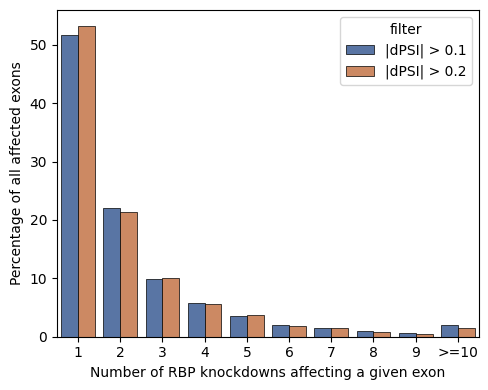

In [5]:
total_occurrences = df.groupby('filter')['value'].sum()
sum_above_20 = df[df['n_occur'] >= 10].groupby('filter')['value'].sum().reset_index()
sum_above_20['n_occur'] = '>=10'
df = df[df['n_occur'] < 10]
df['n_occur'] = df['n_occur'].astype(int)
df = pd.concat([df, sum_above_20])
df['percentage'] = df.apply(lambda row: row['value'] / total_occurrences[row['filter']] * 100, axis=1)
df['n_occur'] = df['n_occur'].astype(str)
plt.figure(figsize=(5, 4))
sns.barplot(x='n_occur', y='percentage', hue='filter', linewidth=0.5, edgecolor='k', data=df, palette='deep')
plt.ylabel('Percentage of all affected exons')
plt.xlabel('Number of RBP knockdowns affecting a given exon')
plt.tight_layout()
plt.savefig('plots/0_rMATs_dPSI_0.1_or_0.2.pdf')

We also wanted to see which RBP knockdows cluster together when looking at co-occurrences of the same exon:

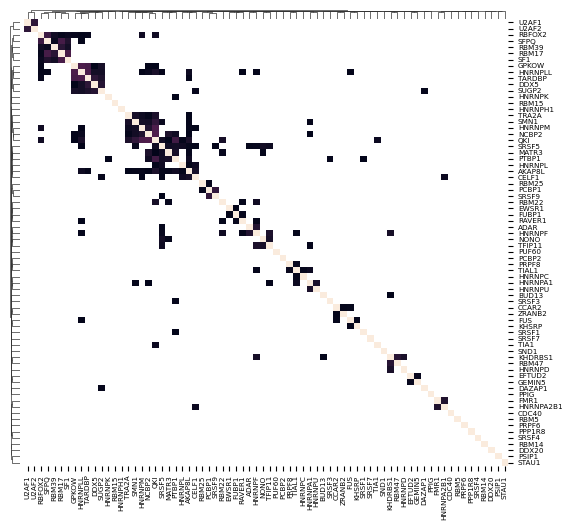

In [59]:
co_ocurrence = pd.crosstab(KD_exons_long.target_coordinates, KD_exons_long.group).corr(
    method="spearman"
)

g = sns.clustermap(
    co_ocurrence,
    yticklabels=True,
    xticklabels=True,
    figsize=(6, 6),
    cbar_pos=None,
    mask=(co_ocurrence > -0.1) & (co_ocurrence < 0.1),
    dendrogram_ratio=0.02,
)

plt.setp(g.ax_heatmap.get_xticklabels(), fontsize=5.25) 
plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=5.25)
g.ax_heatmap.set_xlabel("")
g.ax_heatmap.set_ylabel("")
g.figure.savefig('plots/0_rMATS_co_occurrence.pdf')
plt.show()

Overview of the detected events per RBP

group
U2AF1    2006
U2AF2    1814
SRSF1    1028
PUF60     978
FUBP1     636
         ... 
SND1       10
BUD13       9
CCAR2       7
SRSF4       5
DDX20       5
Length: 72, dtype: int64


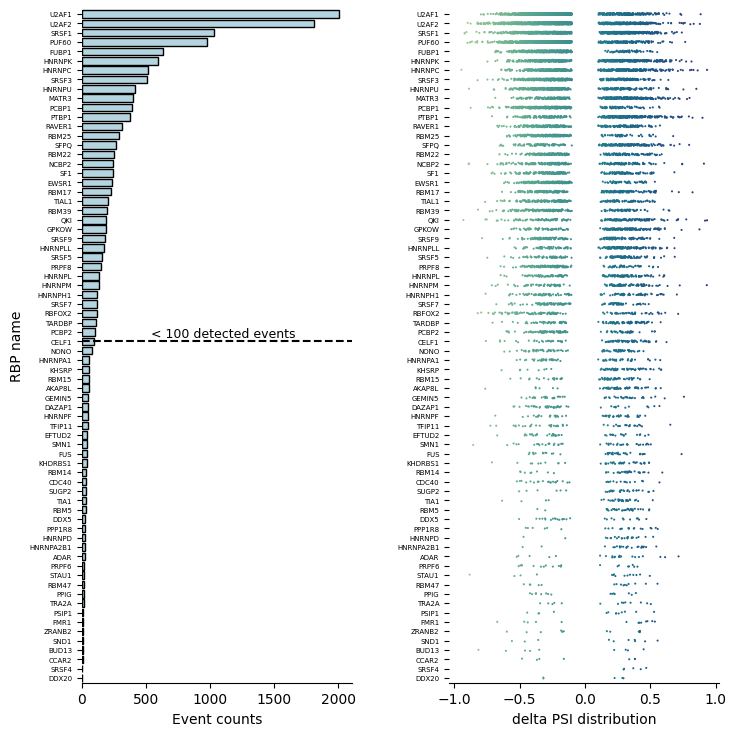

In [70]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
counts_per_rbp = KD_exons_long.groupby(['group']).size().sort_values(ascending=False)
print(counts_per_rbp)
ax1 = sns.barplot(x=counts_per_rbp.values, y=counts_per_rbp.index,
            orient='h', color="lightblue", linewidth=1, edgecolor='black', ax=axes[0])

ax1.set_ylabel('RBP name')
ax1.set_xlabel('Event counts')
plt.ylabel('Number of affected exons')
plt.rc('xtick', labelsize=10)   
plt.rc('ytick', labelsize=5) 
plt.rc('axes', labelsize=10)

for bar, count in zip(ax1.patches, counts_per_rbp.values):
    if count < 100:
        y_pos = bar.get_y() + bar.get_height() / 2
        ax1.axhline(y_pos, color='black', linestyle='--')
        ax1.text(1100, y_pos - 1.5, '< 100 detected events', color='black', ha='center', va='top', fontsize=9) 
        break


ax2 = sns.stripplot(data=KD_exons_long, x='dPSI', y='group', palette="crest", hue='dPSI', legend=False, dodge=False, size=1.5, order=counts_per_rbp.index, ax=axes[1])
sns.despine(left=True)
ax2.set_ylabel('')
ax2.set_xlabel('delta PSI distribution')

f.tight_layout(pad=3.0)
f.savefig('plots/0_rMATS_dPSI_overview.pdf', bbox_inches='tight')

#### Useful dataframes for downstream use

Correlations df:

In [61]:
# Per RBP pearson correlations based on binary data on affected/unnafected exons
correlation_dict = {}
for k, v in co_ocurrence.iterrows():
    d = {_k: _v for _k, _v in v[abs(v) > 0.1].to_dict().items() if _k != k}
    if d:
        correlation_dict[k] = d

# Tidy df
per_rbp_correlations_tidy = (
    pd.DataFrame(correlation_dict)
    .rename_axis("group")
    .reset_index()
    .melt(id_vars="group", var_name="pair", value_name="correlation")
    .dropna()
)

# Wide df
per_rbp_correlations = pd.DataFrame(
    per_rbp_correlations_tidy.groupby("group").apply(
        lambda x: [
            ";".join(x.pair),
            ";".join([str(round(y, 3)) for y in x.correlation]),
        ],
        include_groups=False,
    )
)
per_rbp_correlations[["Correlated_with", "Correlation_value"]] = per_rbp_correlations[
    0
].to_list()
per_rbp_correlations.drop(columns=0, inplace=True)

In [62]:
#################################
### SINGLE RBP AFFECTED EXONS ###
#################################
SINGLE_EXONS = KD_exons_wide[~KD_exons_wide.group.str.contains(',')].copy()
SINGLE_EXONS['dPSI'] = SINGLE_EXONS.dPSI.astype(float)
SINGLE_EXONS_POS_DPSI = SINGLE_EXONS.query('dPSI > 0')
SINGLE_EXONS_NEG_DPSI = SINGLE_EXONS.query('dPSI < 0')

################################
#### TWO RBP AFFECTED EXONS ####
################################
TWO_EXONS = KD_exons_wide[KD_exons_wide.group.apply(lambda x: len(x.split(',')) == 2)]
TWO_EXONS_POS_DPSI = TWO_EXONS[TWO_EXONS.dPSI.apply(lambda x: all(float(y) > 0 for y in x.split(',')))]
TWO_EXONS_NEG_DPSI = TWO_EXONS[TWO_EXONS.dPSI.apply(lambda x: all(float(y) < 0 for y in x.split(',')))]
TWO_EXONS_OPPOSING_DPSI = TWO_EXONS[TWO_EXONS.dPSI.apply(lambda x: any(float(y) > 0 for y in x.split(',')) and any(float(y) < 0 for y in x.split(',')))]